# Weryfikacja efektywności implementacji metod optymalizacji gradientowej
### Łukasz Knigawka & Grzegorz Kopyt
### 2021L

W notatniku przedstawiono eksperymenty z optymalizacją gradientową przy wykorzystaniu języka programowania Julia. 

Jako środowisko uruchomieniowe wykorzystano Google Colab. 
Instalację Julia i wykorzystanie procesorów graficznych dostępnych na platformie przedstawiono poniżej. Domyślnie przy wybraniu akceleracji przy pomocy GPU na Google Colab otrzymujemy niespełna 13GB RAM. Łatwo możemy jednak uzyskać zwiększenie tej wielkości do 25GB -- wystarczy przekroczyć próg ~13GB. Wtedy będziemy niestety musieli od nowa uruchomić komórki, gdyż sesja zostanie zrestartowana. Oczywiście przekroczyć ~13GB jest łatwo, możemy zaalokować ogromną tablicę na starcie i mamy 25GB RAM za darmo (więcej niż na naszych prywatnych komputerach) :) Dodatkową zaletą jest fakt, że współdzielenie środowiska umożliwia dokonywanie pomiarów na tej samej konfiguracji sprzętowej przez obu członków zespołu projektowego.

 Przy realiacji projektu wykorzystywana jest wersja Julii 1.6.0.

## Konfiguracja środowiska uruchomieniowego

In [ ]:
# Installation cell
%%capture
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.6/julia-1.6.0-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

After you run the first cell (the the cell directly above this text), go to Colab's menu bar and select **Edit** and select **Notebook settings** from the drop down. Select *Julia 1.6* in Runtime type. You can also select your prefered harwdware acceleration (defaults to GPU). 

<br/>You should see something like this:

> ![Colab Img](https://raw.githubusercontent.com/Dsantra92/Julia-on-Colab/master/misc/julia_menu.png)

<br/>Click on SAVE
<br/>**We are ready to get going**





In [92]:
VERSION

v"1.6.0"

**The next three cells are for GPU benchmarking. If you are using this notebook for the first time and have GPU enabled, you can give it a try.** 

###GPU Experiments

In [ ]:
using Pkg
Pkg.add(["BenchmarkTools", "CUDA"])
using BenchmarkTools, CUDA

if has_cuda_gpu()
  print("The GPU device is:", CUDA.device())
end

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
   Installed OpenSpecFun_jll ──── v0.5.4+0
   Installed Memoize ──────────── v0.4.4
   Installed BenchmarkTools ───── v0.7.0
   Installed MacroTools ───────── v0.5.6
   Installed SpecialFunctions ─── v1.3.0
   Installed OrderedCollections ─ v1.4.0
   Installed DataStructures ───── v0.18.9
   Installed Compat ───────────── v3.28.0
   Installed Adapt ────────────── v3.3.0
   Installed ChainRulesCore ───── v0.9.41
   Installed RandomNumbers ────── v1.4.0
   Installed LLVM ─────────────── v3.7.0
   Installed Requires ─────────── v1.1.3
   Installed AbstractFFTs ─────── v1.0.1
   Installed TimerOutputs ─────── v0.5.8
   Installed Scratch ──────────── v1.0.3
   Installed Reexport ─────────── v1.0.0
   Installed ExprTools ────────── v0.1.3
   Installed BFloat16s ────────── v0.1.0
   Installed GPUArrays ────────── v6.4.0
   Installed CEnum ────────────── v0.4.1
   Installed CUDA ─────────────── v3.2.0
   In

The GPU device is:CuDevice(0)

In [ ]:
mcpu = rand(2^10, 2^10)
@benchmark mcpu*mcpu

BenchmarkTools.Trial: 
  memory estimate:  8.00 MiB
  allocs estimate:  2
  --------------
  minimum time:     49.824 ms (0.00% GC)
  median time:      52.540 ms (0.00% GC)
  mean time:        52.902 ms (0.66% GC)
  maximum time:     63.441 ms (0.00% GC)
  --------------
  samples:          95
  evals/sample:     1

In [ ]:
println("The CuArrray operation should take around 0.5 ms(excluding CUDA downloading time which is a one time process), and should be much faster. If so, the GPU is working.")
mgpu = cu(mcpu)
@benchmark CUDA.@sync mgpu*mgpu

The CuArrray operation should take around 0.5 ms(excluding CUDA downloading time which is a one time process), and should be much faster. If so, the GPU is working.


BenchmarkTools.Trial: 
  memory estimate:  8.33 KiB
  allocs estimate:  473
  --------------
  minimum time:     353.006 μs (0.00% GC)
  median time:      528.615 μs (0.00% GC)
  mean time:        539.135 μs (0.57% GC)
  maximum time:     14.940 ms (63.88% GC)
  --------------
  samples:          9195
  evals/sample:     1

# Opis projektu (źródło: isod)

Celem projektu jest zweryfikowanie implementacji algorytmów optymalizacji gradientowej przedstawionych w [1]:

- BFGS,
- L-BFGS (Limited Memory BFGS),
- któryś z: Gradient Descent, RMSprop, Nesterov Momentum, Adam, Adadelta, Adagrad.

W ramach projektu należy ocenić czy możliwa jest bardziej efektywna implementacja tych algorytmów. Polegać to będzie na Przykładowo: dla implementacji w języku Julia należy zadbać m.in. o stabilność typów funkcji, wykorzystanie typów konkretnych w definicji struktur i funkcji. W języku Python niezbędne jest wykorzystanie modułu Numba i ogólna inspekcja kodu LLVM.

Porównaniu powinny podlegać: czas znalezienia rozwiązania (z ustaloną dokładnością ϵ

), liczba potrzebnych iteracji oraz ilość allokowanej pamięci w trakcie działania algorytmu. Przeprowadzone porównanie powinno testować wspominane algorytmy w kilku wariantach: tradycyjnych, dwuwymiarowych funkcji celu jak i wielowymiarowych funkcji celu (co najmniej czterowymiarowych).

Tradycyjne, ciekawe funkcje celu to, np.:

- funkcja Rosenbrocka,
- grzbiet Wheelera (ang. Wheeler’s Ridge function),
- funkcja Michalewicza.

Dobrym przykładem wielowymiarowych funkcji celu jest optymalizacja wag w sieciach neuronowych.

Raport końcowy powinien składać się z czterech części:

1. wstępu precyzującego jakie algorytmy i w jakim języku zostały zaimplementowane;
2. opisu badania, przedstawiającego wybrane przypadki testowe, aspekty porównania oraz (najważniejsze) sposoby i warunki ich pomiaru; w warunkach pomiaru proszę uwzględnić parametry środowiska uruchomieniowego: rozmiar i prędkość pamięci, model procesora, model i typ dysku; niezbędne jest wyszczególnienie wszystkich zastosowanych optymalizacji algorytmów;
3. sekcji z wynikami przedstawionymi w odpowiedniej formie wizualnej;
4. podsumowania, odnoszącego się do wyników, obiektywnie zestawiających cechy charakterystyczne tych algorytmów; należy skonfrontować uzyskane wyniki ze spodziewanymi; warto odnieść się w dyskusji do aspektu związane z implementacją algorytmów.

W raporcie końcowym należy załączyć wykresy prezentujące zbieżność porównywanych algorytmów: najlepiej w postaci narysowanych ścieżek na dwuwymiarowym wykresie z zaznaczoną mapą wysokości testowanej funkcji celu -- tylko dla funkcji dwuwymiarowych. Dla testu funkcji o większej wymiarowości należy zastosować wykres wartości funkcji celu od numeru kroku w skali podwójnie logarytmicznej.

[1]:  Mykel J. Kochenderfer, Tim A. Wheeler, 2019, Algorithms for Optimization, MIT Press.

Sekcje teoretyczne powstają głównie w oparciu o wykład z przedmiotu *Algorytmy w Inżynierii Danych*.

[comment]: # (ponizsze punkty to takie, które wg isod powinny się znaleźć w sprawozdaniu końcowym -- jak zaczniemy tutaj nasze przemyślenia/nawet luźniejsze teksty przyporządkowywać do tych sekcji, to łatwiej będzie to pozbierać w końcowe sprawozdanie)
# Opis problemu

Zadaniem algorytmów optymalizacyjnych jest przeszukanie przestrzeni rozwiązań w celu znalezienia takiego, którego wartość funkcji celu jest najmniejsza.
Aby odnaleźć punkt optymalny, algorytmy optymalizacji mogą polegać na gradiencie i macierzy Hessego (drugich pochodnych) funkcji celu. Optymalizaując wiele parametrów, część z nich może się okazać mało istotna w poszukiwaniu punktu optymalnego. 

Metody pierwszego rzędu opierają się na informacji o gradiencie optymalizowanej funkcji. 


## O czym pamiętać pisząc efektywne algorytmy? (na podstawie Wykładu 08)
Opracowanie powstało, aby zebrać informacje nt. pisania efektywnego kodu w Julii i wiedzę tę wykorzystać przy projekcie. 
- W Julii mamy makro `@time`, które bada czas działania i rozmiar alokowanej pamięci.
- Pakiet `BenchmarTools` posiada makro `@btime`, które wielokrotnie uruchamia kod. Importujemy przy pomocy `import BenchmarkTools: @btime`, następnie w wybranej linijce na początku zawieramy makro. Na przykład `@btime copy_row_col!(out, x);`
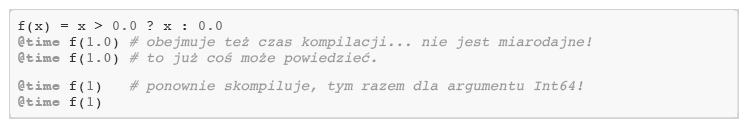
- Gdzie tylko możemy, deklarujmy typu zmiennych/obiektów, nawet jeśli da się to ominąć.
- Domyślnie wycinanie kawałka macierzy tworzy kopię. Rezygnacja z kopiowania na rzecz widoku może przyspieszyć program. Dla wygody możemy skorzystać z makra `@views` , które automatycznie zamienia kopiowanie na
tworzenie widoku. Przykładowe użycie: `@views fview(x) = sum(x[2:end-1]);`.


## Na czym uruchamiamy kod?

In [ ]:
!cat /proc/cpuinfo

LoadError: ignored

In [ ]:
!df -h

LoadError: ignored

## Instalacja bibliotek

In [ ]:
using Pkg
Pkg.add(["Plots", "Flux", "PGFPlots", "LinearAlgebra", "LaTeXStrings", "Colors", "ColorSchemes", "Images", "PyPlot", "TikzPictures"])

   Resolving package versions...
    Updating `~/.julia/environments/v1.6/Project.toml`
  [37f6aa50] + TikzPictures v3.3.3
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [ ]:
import Pkg
Pkg.add(PackageSpec(url="https://github.com/sisl/Vec.jl.git"))

    Updating git-repo `https://github.com/sisl/Vec.jl.git`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [ ]:
Pkg.installed()

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Pkg/src/Pkg.jl:565


Dict{String, VersionNumber} with 10 entries:
  "CUDA"           => v"3.2.0"
  "ColorSchemes"   => v"3.12.1"
  "Vec"            => v"2.0.2"
  "IJulia"         => v"1.23.2"
  "Plots"          => v"1.13.2"
  "PGFPlots"       => v"3.3.7"
  "Flux"           => v"0.12.3"
  "BenchmarkTools" => v"0.7.0"
  "Colors"         => v"0.12.8"
  "LaTeXStrings"   => v"1.2.1"

# Implementacje (kod)
Implemetacje algorytmów zaproponowane w pozycji [1] dostępne są pod [tym](https://github.com/sisl/algforopt-notebooks) adresem.




In [ ]:
abstract type DescentMethod end

## Metody pierwszego rzędu



## Adam


In [ ]:
mutable struct Adam <: DescentMethod
α # learning rate
ε # small value
v # sum gradient
s # sum of squared gradient
γs # gradient decay
γv # momentum decay
k # step counter
Adam() = new() # new uninitialized structure
end

function init!(M::Adam, θ; α=0.001, γv=0.9, γs=0.999, ε=1e-8)
M.α = α
M.ε = ε
M.γs = γs
M.γv = γv
M.s = zero(θ)
M.v = zero(θ)
M.k = 0
return M
end

function step!(M::Adam, f, ∇f, θ)
γs, γv = M.γs, M.γv
α, ε, k = M.α, M.ε, M.k
s, v, g = M.s, M.v, ∇f(θ)
v[:] = γv*v + (1.0 - γv) * g
s[:] = γs*s + (1.0 - γs) * g .* g
M.k = k += 1
v̂ = v ./ (1.0 - γv^k)
ŝ = s ./ (1.0 - γs^k)
return θ - α*v̂ ./ (sqrt.(ŝ) .+ ε)
end

step! (generic function with 1 method)

## Metody drugiego rzędu


## BFGS

In [96]:
using Vec
using LinearAlgebra

function _line_search(f, x, d)
    d = normalize(d)
    objective = α -> f(x + α*d)
    v, α = f(x), 1e-6
    while f(x + α*d) < v
        v = f(x + α*d)
        α += 1e-6
    end
    return x + α*d
end

abstract type DescentMethod end
mutable struct DFP <: DescentMethod
	Q
end
function init!(M::DFP, f, ∇f, x)
	M.Q = Matrix(1.0I, length(x), length(x))
	return M
end
function step!(M::DFP, f, ∇f, x)
	Q, g = M.Q, ∇f(x)
	x′ = _line_search(f, x, -Q*g)
	g′ = ∇f(x′)
	δ = x′ - x
    γ = g′ - g
    Q[:] = Q - Q*γ*γ'*Q/(γ'*Q*γ) + δ*δ'/(δ'*γ)
    return x′
end

mutable struct BFGS <: DescentMethod
	Q
end
function init!(M::BFGS, f, ∇f, x)
	M.Q = Matrix(1.0I, length(x), length(x))
	return M
end
function step!(M::BFGS, f, ∇f, x)
	Q, g = M.Q, ∇f(x)
	x′ = _line_search(f, x, -Q*g)
	g′ = ∇f(x′)
	δ = x′ - x
    γ = g′ - g
    Q[:] = Q - (δ*γ'*Q + Q*γ*δ')/(δ'*γ) + (1 + (γ'*Q*γ)/(δ'*γ))[1]*(δ*δ')/(δ'*γ)
    return x′
end

step! (generic function with 5 methods)

## Limited-memory BFGS

In [ ]:
mutable struct LimitedMemoryBFGS <: DescentMethod
	m
	δs
	γs
	qs
end
function init!(M::LimitedMemoryBFGS, f, ∇f, x)
	M.δs = []
	M.γs = []
    M.qs = []
	return M
end
function step!(M::LimitedMemoryBFGS, f, ∇f, x)
    δs, γs, qs, g = M.δs, M.γs, M.qs, ∇f(x)
    m = length(δs)
    if m > 0
        q = g
        for i in m : -1 : 1
            qs[i] = copy(q)
            q -= (δs[i]⋅q)/(γs[i]⋅δs[i])*γs[i]
        end
        z = (γs[m] .* δs[m] .* q) / (γs[m]⋅γs[m])
        for i in 1 : m
            z += δs[i]*(δs[i]⋅qs[i] - γs[i]⋅z)/(γs[i]⋅δs[i])
        end
        x′ = _line_search(f, x, -z)
    else
        x′ = _line_search(f, x, -g)
    end
    g′ = ∇f(x′)
    push!(δs, x′ - x); push!(γs, g′ - g)
    push!(qs, zeros(length(x)))
    while length(δs) > M.m
        popfirst!(δs); popfirst!(γs); popfirst!(qs)
    end
    return x′
end

step! (generic function with 4 methods)

## Funkcje celu

Te fragmenty kodu generują obrazki z funkcjami :)

In [ ]:
include("support_code.jl");

Funkcja Rosenbrocka

In [ ]:
p = let
	rosenbrock(x; a=1, b=5) = (a-x[1])^2 + b*(x[2] - x[1]^2)^2

	xdomain = (-2, 2)
	ydomain = (-2, 2)

	plots = PGFPlots.Plot[]
	push!(plots, PGFPlots.Contour(rosenbrock, xdomain, ydomain, levels=[1,2,3,5,10,20,50,100], style="width=\\columnwidth", xbins=100, ybins=100))
	Axis(plots, width="8cm", height="8cm", xlabel=L"x_1", ylabel=L"x_2", style="contour/labels=false, axis equal, view={0}{90}")
end

PGFPlots.plot(p)

TikzPicture("\\begin{axis}[\n  height = {8cm},\n  ylabel = {\$x_2\$},\n  xlabel = {\$x_1\$},\n  contour/labels=false, axis equal, view={0}{90},\n  width = {8cm}\n]\n\n\\addplot3[\n  contour prepared,\n  width=\\columnwidth\n] table {\n  1.5398274644658336 2.0 1.0\n  1.52792559163049 1.9595959595959596 1.0\n  1.51693233696514 1.9191919191919191 1.0\n  1.5151515151515151 1.9126662245349113 1.0\n  1.5036143267125885 1.878787878787879 1.0\n  1.4909619932667015 1.8383838383838385 1.0\n  1.4793224142433328 1.797979797979798 1.0\n  1.4747474747474747 1.7817760169406125 1.0\n  1.4662724646948102 1.7575757575757576 1.0\n  1.4529433131884442 1.7171717171717171 1.0\n  1.4407105145970358 1.6767676767676767 1.0\n  1.4343434343434343 1.6550185452209767 1.0\n  1.427619252278551 1.6363636363636365 1.0\n  1.4137081567084486 1.595959595959596 1.0\n  1.4009510785846657 1.5555555555555556 1.0\n  1.393939393939394 1.5325035779581238 1.0\n  1.3874957922310878 1.5151515151515151 1.0\n  1.3731109840372666 1.4

Wheeler

In [ ]:
using TikzPictures

p = let
	wheeler(x, a=1.5) = -exp(-(x[1]*x[2] - a)^2 -(x[2]-a)^2)

	xdom = (-8,25)
	ydom = (-3,6)

	Axis(PGFPlots.Image((x,y)->wheeler([x,y]), xdom, ydom, xbins=1200, ybins=480, colormap = pasteljet, colorbar = false),
	     xmin=xdom[1], xmax=xdom[2], ymin=ydom[1], ymax=ydom[2], width="12cm", height="4.8cm", style="view={0}{90}", xlabel=L"x_1", ylabel=L"x_2")
end

PGFPlots.plot(p)

TikzPicture("\\begin{axis}[\n  height = {4.8cm},\n  ylabel = {\$x_2\$},\n  xmin = {-8},\n  xmax = {25},\n  ymax = {6},\n  xlabel = {\$x_1\$},\n  view={0}{90},\n  ymin = {-3},\n  width = {12cm},\n  enlargelimits = false,\n  axis on top\n]\n\n\\addplot[\n  point meta min = -0.999823499610959,\n  point meta max = -0.0\n] graphics[\n  xmin = -8,\n  xmax = 25,\n  ymin = -3,\n  ymax = 6\n] {tmp_10000000000013.png};\n\n\\end{axis}", "", "\\usepackage{pgfplots}\n\\pgfplotsset{compat=newest}\n\\pgfplotsset{every axis legend/.append style={%\ncells={anchor=west}}\n}\n\\usetikzlibrary{arrows}\n\\tikzset{>=stealth'}\n\n\\pgfplotscreateplotcyclelist{pastelcolors}{%\n  solid, pastelPurple, mark=none\\\\%\n  solid, pastelBlue, mark=none\\\\%\n  solid, pastelGreen, mark=none\\\\%\n  solid, pastelRed, mark=none\\\\%\n  solid, pastelMagenta, mark=none\\\\%\n  solid, pastelOrange, mark=none\\\\%\n  solid, pastelSeaGreen, mark=none\\\\%\n}\n\\usepackage{amsmath}\n\\usepackage{xfrac}\n\\usepgfplotslibrary{

Michalewicz

In [ ]:
p = let
michalewicz(x; m=10) = -sum(sin(v)*sin(i*v^2/π)^(2m) for (i,v) in enumerate(x))

xdomain = (0, 4)
ydomain = (0, 4)

plots = Plots.Plot[]
# push!(plots, Plots.Contour(michalewicz, xdomain, ydomain, levels=[-1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2], style="width=\\columnwidth", xbins=101, ybins=101))
# Axis(plots, width="8cm", height="8cm", xlabel=L"x_1", ylabel=L"x_2", style="contour/labels=false, axis equal, view={0}{90}")
Axis(PGFPlots.Image((x,y)->michalewicz([x,y]), xdomain, ydomain, xbins=600, ybins=600, colormap = pasteljet, colorbar = false),
xmin=xdomain[1], xmax=xdomain[2], ymin=ydomain[1], ymax=ydomain[2], width="8cm", height="8cm", style="view={0}{90}", xlabel=L"x_1", ylabel=L"x_2")
end

PGFPlots.plot(p)

TikzPicture("\\begin{axis}[\n  height = {8cm},\n  ylabel = {\$x_2\$},\n  xmin = {0},\n  xmax = {4},\n  ymax = {4},\n  xlabel = {\$x_1\$},\n  view={0}{90},\n  ymin = {0},\n  width = {8cm},\n  enlargelimits = false,\n  axis on top\n]\n\n\\addplot[\n  point meta min = -1.8012010742431048,\n  point meta max = 1.0175243954563755\n] graphics[\n  xmin = 0,\n  xmax = 4,\n  ymin = 0,\n  ymax = 4\n] {tmp_10000000000012.png};\n\n\\end{axis}", "", "\\usepackage{pgfplots}\n\\pgfplotsset{compat=newest}\n\\pgfplotsset{every axis legend/.append style={%\ncells={anchor=west}}\n}\n\\usetikzlibrary{arrows}\n\\tikzset{>=stealth'}\n\n\\pgfplotscreateplotcyclelist{pastelcolors}{%\n  solid, pastelPurple, mark=none\\\\%\n  solid, pastelBlue, mark=none\\\\%\n  solid, pastelGreen, mark=none\\\\%\n  solid, pastelRed, mark=none\\\\%\n  solid, pastelMagenta, mark=none\\\\%\n  solid, pastelOrange, mark=none\\\\%\n  solid, pastelSeaGreen, mark=none\\\\%\n}\n\\usepackage{amsmath}\n\\usepackage{xfrac}\n\\usepgfplotsli

## Test Adam

In [101]:
p = let
  # ROSENBROCK 2D
  f = x -> (1-x[1])^2 + 100*(4x[2] - x[1]^2)^2
  ∇f = x -> [2*(200x[1]^3 - 800x[1]*x[2] + x[1] - 1), -800*(x[1]^2 - 4x[2])]
  xdomain = (-2.5, 1.4)
  ydomain = (-0.2, 1.7)
  x₀ = VecE2{Float64}(-2,1.5)
  function this_step!(M::DescentMethod, v::VecE2{Float64})
      x = Float64[v.x, v.y]
      return VecE2{Float64}(step!(M, f, ∇f, x)...)
  end
  function run_descent_method(M::DescentMethod, x₀::VecE2{Float64}, N::Int16)
      pts = [x₀]
      init!(M, f, ∇f, convert(Vector{Float64}, x₀))
      for i in 1 : N
          push!(pts, this_step!(M, pts[end]))
      end
   # println(pts[end])
      return pts
  end
  function get_descent_plot(pts::Vector{VecE2{Float64}}, name, color::String="black")
      PGFPlots.Linear([P.x for P in pts], [P.y for P in pts], style="thick,
    $color, solid, mark=none, line join=round", legendentry=name) #$
  end
  stuff = Tuple{DescentMethod, String, String, Int16}[]
  push!(stuff, (BFGS(Matrix(1.0I, 2, 2)), "BFGS", "pastelOrange", 22))
  plots = PGFPlots.Plot[]
  push!(plots, PGFPlots.Contour(f, xdomain, ydomain, levels=[5,50,200,500,1000,2000],
   style="forget plot, width=\\columnwidth", xbins=150, ybins=150))
  for (M, name, color, N) in stuff
      pts = run_descent_method(M, x₀, N)
      push!(plots, get_descent_plot(pts, name, color))
  end
  Axis(plots, width="12cm", height="7cm", xlabel=L"x_1", ylabel=L"x_2",
   style="xtick=\\empty, ytick=\\empty, contour/labels=false, view={0}{90}, legend pos=outer north east")
 end
 PGFPlots.plot(p)

TikzPicture("\\begin{axis}[\n  height = {7cm},\n  ylabel = {\$x_2\$},\n  xlabel = {\$x_1\$},\n  xtick=\\empty, ytick=\\empty, contour/labels=false, view={0}{90}, legend pos=outer north east,\n  width = {12cm}\n]\n\n\\addplot3[\n  contour prepared,\n  forget plot, width=\\columnwidth\n] table {\n  1.4 0.5446453273622712 5.0\n  1.3930139215609165 0.5395973154362416 5.0\n  1.3738255033557047 0.5269518991013521 5.0\n  1.373674718818293 0.5268456375838926 5.0\n  1.3557048531459708 0.5140939597315436 5.0\n  1.3476510067114094 0.5089063007271483 5.0\n  1.336731194042611 0.5013422818791946 5.0\n  1.3214765100671142 0.49162863101158705 5.0\n  1.3169782766889206 0.4885906040268456 5.0\n  1.297054852046277 0.47583892617449663 5.0\n  1.2953020134228188 0.4747491010215418 5.0\n  1.277723224816417 0.46308724832214765 5.0\n  1.2691275167785234 0.4578099608787881 5.0\n  1.2575658358390474 0.45033557046979866 5.0\n  1.2429530201342283 0.4414919631809033 5.0\n  1.236752238301751 0.4375838926174497 5.0\n